In [66]:
import numpy as np
import pandas as pd
import chromATAC as ca
from chromATAC.integrated import IntData
from pycirclize import Circos
from pycirclize.utils import ColorCycler
import collections
import matplotlib.pyplot as plt
from pathlib import Path
import os
from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset
from tqdm import tqdm
import seaborn as sns

In [ ]:
sns.stripplot

In [ ]:
spl = StackPlot(figsize=(12, 4), show_borders=True)
line = spl.add_track((start_percentage, end_percentage), name='line plot')
track.lineplot()
scatter = spl.add_track((start_percentage, end_percentage), name='scatter plot')
track.scatterplot()
strip = spl.add_track((start_percentage, end_percentage), name='strip plot')
track.stripplot()
rect = spl.add_track(portions=[0.1, 0.8, 0.1], color=[], text=[], )


class ColorCycler:
    """Color Cycler Class"""

    counter = 0
    cmap: Colormap = mpl.colormaps["tab10"]

    def __new__(cls, n: int | None = None) -> str:
        """Get hexcolor cyclically from cmap by counter or user specified number

        `ColorCycler()` works same as `ColorCycler.get_color()`

        Parameters
        ----------
        n : int | None, optional
            Number for color cycle. If None, counter class variable is used.

        Returns
        -------
        hexcolor : str
            Cyclic hexcolor string
        """
        return cls.get_color(n)

    @classmethod
    def reset_cycle(cls) -> None:
        """Reset cycle counter"""
        cls.counter = 0

    @classmethod
    def set_cmap(cls, name: str) -> None:
        """Set colormap (Default: `tab10`)"""
        cls.cmap = mpl.colormaps[name]
        cls.counter = 0

    @classmethod
    def get_color(cls, n: int | None = None) -> str:
        """Get hexcolor cyclically from cmap by counter or user specified number

        Parameters
        ----------
        n : int | None, optional
            Number for color cycle. If None, counter class variable is used.

        Returns
        -------
        hexcolor : str
            Cyclic hexcolor string
        """
        if n is None:
            n = cls.counter
            cls.counter += 1
        return to_hex(cls.cmap(n % cls.cmap.N), keep_alpha=True)

    @classmethod
    def get_color_list(cls, n: int | None = None) -> list[str]:
        """Get hexcolor list of colormap

        Parameters
        ----------
        n : int | None, optional
            If n is None, all(=cmap.N) hexcolors are extracted from colormap.
            If n is specified, hexcolors are extracted from n equally divided colormap.

        Returns
        -------
        hexcolor_list : list[str]
            Hexcolor list
        """
        if n is None:
            cmap_idx_list = list(range(0, cls.cmap.N))
        elif n > 0:
            cmap_idx_list = [int(i) for i in np.linspace(0, cls.cmap.N, n)]
        else:
            raise ValueError(f"{n=} is invalid number (Must be 'n > 0').")

        return [to_hex(cls.cmap(i), keep_alpha=True) for i in cmap_idx_list]


In [11]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'

In [12]:
tes_dir = parent_dir+'/data/V2-TEs/non_olap'
cotes_dir = parent_dir+'/data/V2-TEs/non_olap/cores1000/'

In [13]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTEs = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [14]:
te_meta = pd.read_csv(parent_dir+'/analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTEs)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [15]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/n_clusters_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_clusters'])

In [16]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)
te_df.set_index('repname_numbered', inplace=True)

-------

In [17]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path, index_col=False)
    df = df.rename(columns={'Unnamed: 0': 'CoTE'})
    df['CoTE'] = df['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df.rename({i: i.split(':')[-1] for i in df.columns}, axis=1, inplace=True)
    df = df.set_index('CoTE')
    return df
def adjust_tables(df_gain, df_loss):
    gc = list(set(list(df_gain.columns)) - set(list(df_loss.columns)))
    for c in gc:
        df_loss[c]=1
    lc = list(set(list(df_loss.columns)) - set(list(df_gain.columns)))
    for c in gc:
        df_gain[c]=1
    
def lg_heatmap(c = 'chr8', orient='h', exp=11):
    df_gain = pd.read_csv(parent_dir+f'/analysis/experiment{exp}/gain/{c}__qval_n_hit.csv', index_col=False)
    df_gain = df_gain.rename(columns={'Unnamed: 0': 'CoTE'})
    df_gain['CoTE'] = df_gain['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df_gain.rename({i:i.split(':')[-1] for i in df_gain.columns}, axis=1, inplace=True)
    df_gain = df_gain.set_index('CoTE')
    
    df_loss = pd.read_csv(parent_dir+f'/analysis/experiment{exp}/loss/{c}__qval_n_hit.csv', index_col=False)
    df_loss = df_loss.rename(columns={'Unnamed: 0': 'CoTE'})
    df_loss['CoTE'] = df_loss['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df_loss.rename({i:i.split(':')[-1] for i in df_loss.columns}, axis=1, inplace=True)
    df_loss = df_loss.set_index('CoTE')
    adjust_tables(df_gain, df_loss)
    row_linkage = hierarchy.linkage(df_gain, method='average')
    col_linkage = hierarchy.linkage(df_gain.T, method='average')
    row_order = hierarchy.leaves_list(row_linkage)
    col_order = hierarchy.leaves_list(col_linkage)
    # plt.show()
    vmin = 0
    vmax = 1
    fig, axs = plt.subplots(2, 1, figsize=(70, 15), sharex=True) if orient=='h' else plt.subplots(1, 2, figsize=(15, 70))
    plt.suptitle(f'Copy Number Variation in different Cancer types vs Prescence/Abscence of CoTE in Mbp of {c}', fontsize=16, ha='center')
    sns.heatmap(df_gain.iloc[row_order, col_order] if orient=='v' else df_gain.T.iloc[col_order, row_order], square=False, ax=axs.flatten()[0], cbar=False, vmin=vmin, vmax=vmax)
    axs.flatten()[0].set_title('CNV Gain Locus', fontsize=16)
    sns.heatmap(df_loss.iloc[row_order, col_order] if orient=='v' else df_loss.T.iloc[col_order, row_order], square=False, ax=axs.flatten()[1], cbar=False, vmin=vmin, vmax=vmax)
    axs.flatten()[1].set_title('CNV Loss Locus', fontsize=16)
    for ax in axs.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(90)  # Rotate the x-tick labels to 45 degrees
            label.set_fontsize('x-small')  # Set the font size to 'x-small' or any appropriate size
        for label in ax.get_yticklabels():
            label.set_fontsize('x-small')  # Set the font size for y-tick labels
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(left=0.15)  # Adjust as needed
    plt.subplots_adjust(hspace=0.2)
    
    plt.show()
    # fig.savefig
    return df_gain, df_loss, fig
def TE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def CoTE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations
    
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples])
        annotations[c] = ann
    return conditions, annotations

def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for c in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][c]])
        conditions[c] = np.array([int(i in idx) for i in chromosome_layer['index'][c]])
        annotations[c] = ann
    return conditions, annotations

In [18]:
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')

In [21]:
ind = IntData()
ind.add_layer("TEs", input=parent_dir+'/data/V2-TEs/non_olap', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CoTEs", input=parent_dir+'/data/V2-TEs/non_olap/cores1000', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CNVAR", input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal', resolutions=[1e06, 1e07],)
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'])

loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/non_olap


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:09<00:00, 102.57it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/non_olap/cores1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 1145.69it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData/data/CNVAR/segments/beds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:25<00:00,  3.58s/it]


In [32]:
te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)

/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_38811/101954363.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)


In [171]:
def plot_circos(c, te_family='542_L1MA1', **kwargs):
    
    np.random.seed(0)
    ColorCycler.set_cmap("tab10")
    chr_bed_file = Path(f'./chromosomes/{c}.bed')
    cytoband_file = Path('./cytoBand.txt')
    bar_x, bar_y = kwargs.get('bar_x'), kwargs.get('bar_y')
    k = [te_family in i for i in TEs]
    te_family = TEs[k][0]
    te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)
    te_df = te_df[te_df['chr']==c][['chr', 'start', 'end']]
    
    cote_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/cores1000/{te_family}.bed',sep='\t', names=['chr', 'start', 'end'], index_col=False)
    cote_df = cote_df[cote_df['chr']==c][['chr', 'start', 'end']]
    # Initialize Circos from BED chromosomes
    circos = Circos.initialize_from_bed(chr_bed_file, space=3, start=45, end=360, endspace=False)
    # circos.text("Homo sapiens (hg38)", size=15)
    
    circos.add_cytoband_tracks((97, 100), cytoband_file, )
        
    for sector in circos.sectors:
        megabp = sector.add_track((92, 97))
        rect_size = 1e07
        for i in range(int(megabp.size / rect_size)+1):
            x1, x2 = i * rect_size, min(i * rect_size + rect_size, sector.size)
            megabp.rect(x1, x2, ec="black", lw=0.5, color=ColorCycler())
            megabp.text(str(i + 1)+' Mbp', (x1 + x2) / 2, size=8, color="white")
            
        te = sector.add_track((83, 92))
        te.rect(0, te.size, fc='khaki')
        for (chr, start, end) in te_df.values:
            te.rect(start, end, color='mediumseagreen', ec='mediumseagreen', lw=.08, alpha=.3)
            
        cote = sector.add_track((73, 83), )
        cote.rect(0, cote.size, fc='lightgoldenrodyellow')
        for (chr, start, end) in cote_df.values:
            cote.rect(start, end, color='seagreen')
            
        bar_track = sector.add_track((40, 73), r_pad_ratio=0.1)
        bar_track.axis()
        bar_track.scatter(bar_x, bar_y, color="green", s=2)

    text_common_kws = dict(ha="left", va="center", size=8)
    circos.text(" 1. Idiogram", r=98.5, color="black", **text_common_kws)
    circos.text(" 2. Mega Base Pairs", r=95, color="black", **text_common_kws)
    circos.text(" 3. (TE) Transpose Elements -> L1MA1 Family", r=87.5, color="black", **text_common_kws)
    circos.text(" 4. (CoTE) Clusters of Transpose Elements -> L1MA1 Family", r=78, color="black", **text_common_kws)
    fig = circos.plotfig()
    fig.savefig(f"./{c}_circos.png")

In [154]:
def process_array(arr):
    flattened_array = []
    index_array = []
    
    for row in arr:
        for index, value in enumerate(row, start=0):
            flattened_array.append(value)
            index_array.append(index*1e06)
    
    return index_array, flattened_array

In [155]:
bar_x, bar_y = process_array(f)

/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_38811/1725334098.py:10: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)


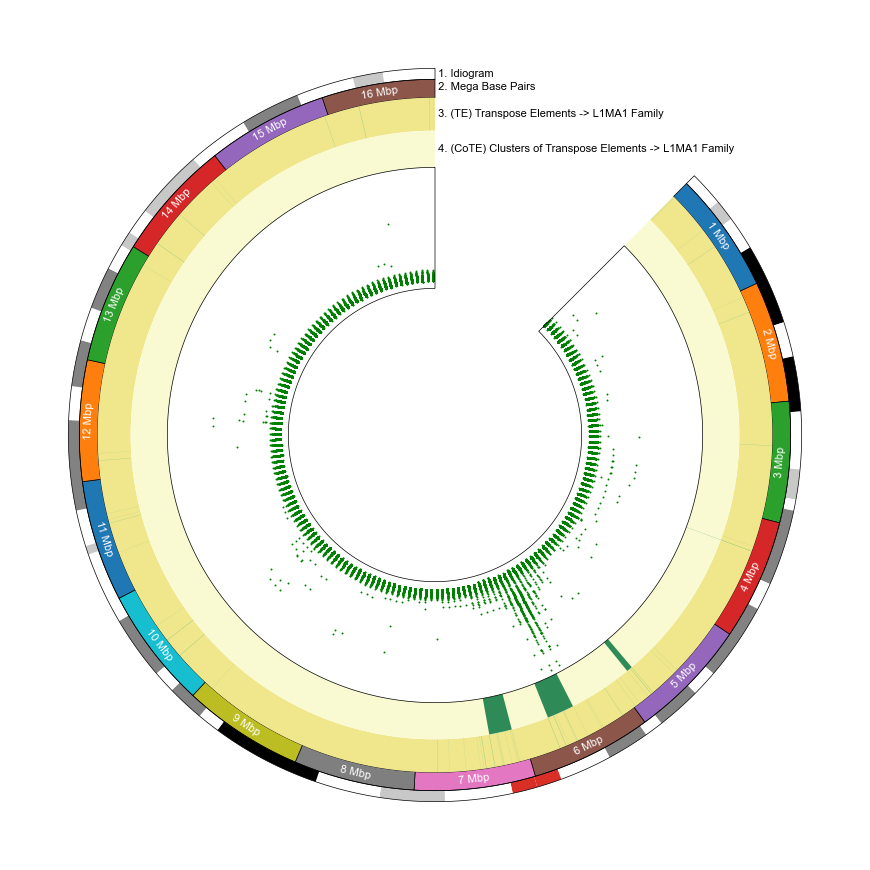

In [172]:
c = 'chr7'
te_family = 'LTR56'
plot_circos(c=c, te_family=te_family, bar_x=bar_x, bar_y = bar_y)

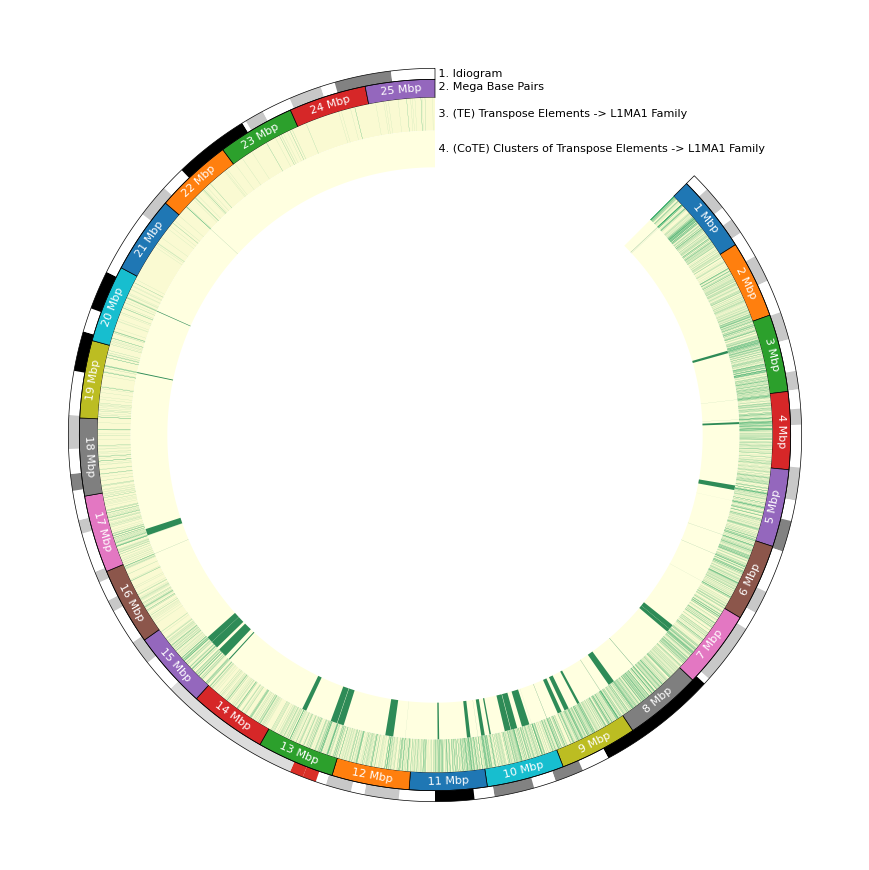

In [14]:
C = 'chrX'

te_df = pd.read_csv('/cluster/home/t124771uhn/data/V2-TEs/non_olap/542_L1MA1_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)
te_df[te_df['chr']==C][['start', 'end']].values
cote_df = pd.read_csv('/cluster/home/t124771uhn/data/V2-TEs/non_olap/cores1000/542_L1MA1_Merged.bed',sep='\t', names=['chr', 'start', 'end'], index_col=False)
cote_df[cote_df['chr']==C][['start', 'end']].values

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3, start=45, end=360, endspace=False)
# circos.text("T", size=15)
circos.add_cytoband_tracks((97, 100), cytoband_file)
for sector in circos.sectors:
    megabp = sector.add_track((92, 97))
    rect_size = 1e07
    for i in range(int(megabp.size / rect_size)+1):
        x1, x2 = i * rect_size, min(i * rect_size + rect_size, sector.size)
        megabp.rect(x1, x2, ec="black", lw=0.5, color=ColorCycler())
        megabp.text(str(i + 1)+' Mbp', (x1 + x2) / 2, size=8, color="white")
        
    te = sector.add_track((83, 92))
    te.rect(0, cote.size, fc='lightgoldenrodyellow')
    for (chr, start, end) in te_df.values:
        te.rect(start, end, color='mediumseagreen', ec='mediumseagreen', lw=.08, alpha=.3)
        
    cote = sector.add_track((73, 83), )
    cote.rect(0, cote.size, fc='lightyellow')
    for (chr, start, end) in cote_df.values:
        cote.rect(start, end, color='seagreen')


text_common_kws = dict(ha="left", va="center", size=8)
circos.text(" 1. Idiogram", r=98.5, color="black", **text_common_kws)
circos.text(" 2. Mega Base Pairs", r=95, color="black", **text_common_kws)
circos.text(" 3. (TE) Transpose Elements -> L1MA1 Family", r=87.5, color="black", **text_common_kws)
circos.text(" 4. (CoTE) Clusters of Transpose Elements -> L1MA1 Family", r=78, color="black", **text_common_kws)
fig = circos.plotfig()

In [61]:
ind.chr.add_filter('CoTEs', Clustered_TEs, ['TEs'])
ind.chr.add_filter('te_family', TE_family, ['TEs'])
ind.chr.add_filter('cote_family', CoTE_family, ['CoTEs'])

In [286]:
def cdriver_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con = {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for chr in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][chr]
        conditions[chr] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples])
        annotations[chr] = ann
    return conditions, annotations

In [287]:
chroms = ca.info.CHROMOSOMES['names'][:-1]

['813_LTR56', '1002_MER4A1', '129_AluYk3', '1009_MER4D1', '287_Charlie10', '456_HAL1b', '964_MER31B', '568_L1MCa']
figure saved at /Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/figure.png


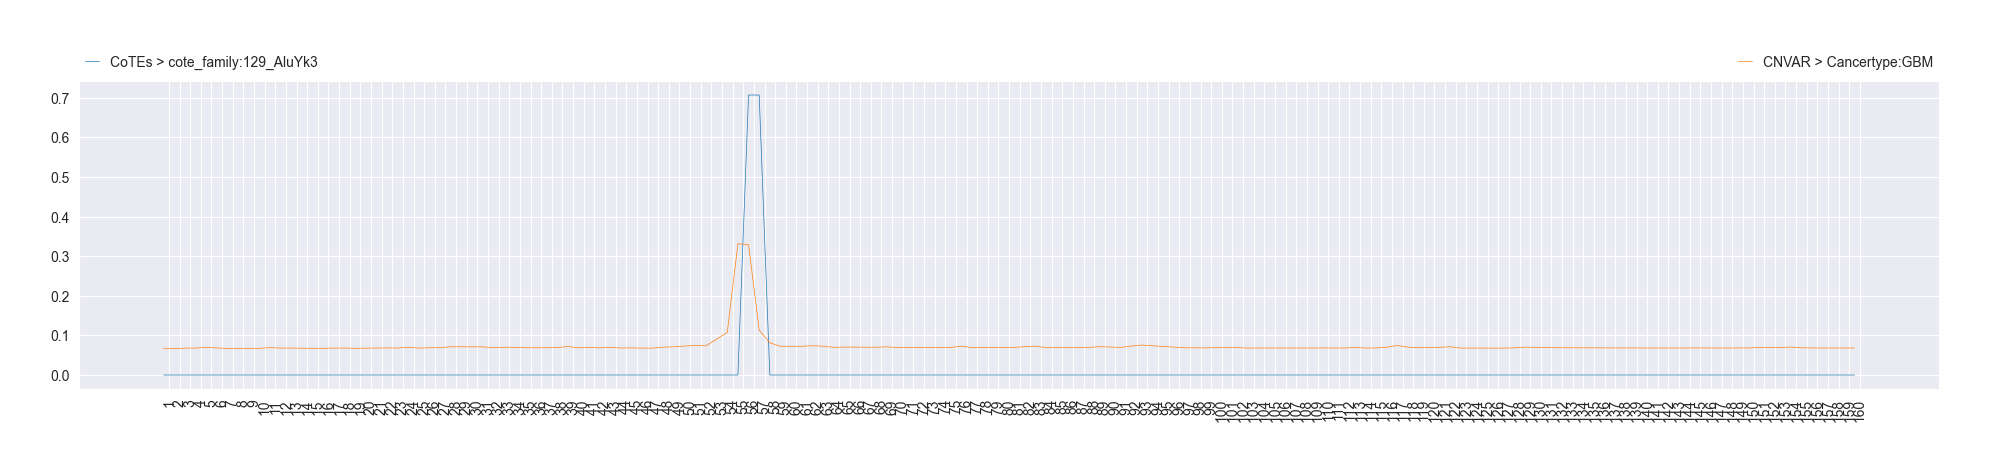

In [62]:
c = 'chr7'
ct = 'GBM'
df = pd.read_csv(parent_dir+f'/analysis/experiment16/gain/{c}__qval_n_hit.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
q_ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}')

df = pd.read_csv(parent_dir+f'/analysis/experiment16/gain/{c}__n_hits.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}', ascending=False)

families = [i.split('>')[-1] for i in q_ct_df.loc[q_ct_df.values<=0.031].index.values]
print(families)
ca.pl.match_layers(ind.chr, ['CoTEs', 'CNVAR'], chrom=c, groups={'CNVAR':{'Cancertype':[ct]}, 
                                                                    'CoTEs':{'cote_family':families[2]}}, qnormalize=False,
                                               aggregation='sum',
                                               save_fig=True, 
                                               path='/Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/')

In [82]:
f.shape

(511, 160)

In [84]:
d = ind.chr.get_layer('CNVAR', groups={'Cancertype':[ct]}, chrom=c)
f = d['Cancertype'][ct]['data']
id = d['Cancertype'][ct]['index']

In [68]:
tf = families[2]
g = ind.chr.get_layer('CoTEs', chrom=c, groups={'cote_family':tf})
j = g['cote_family'][tf]['data']

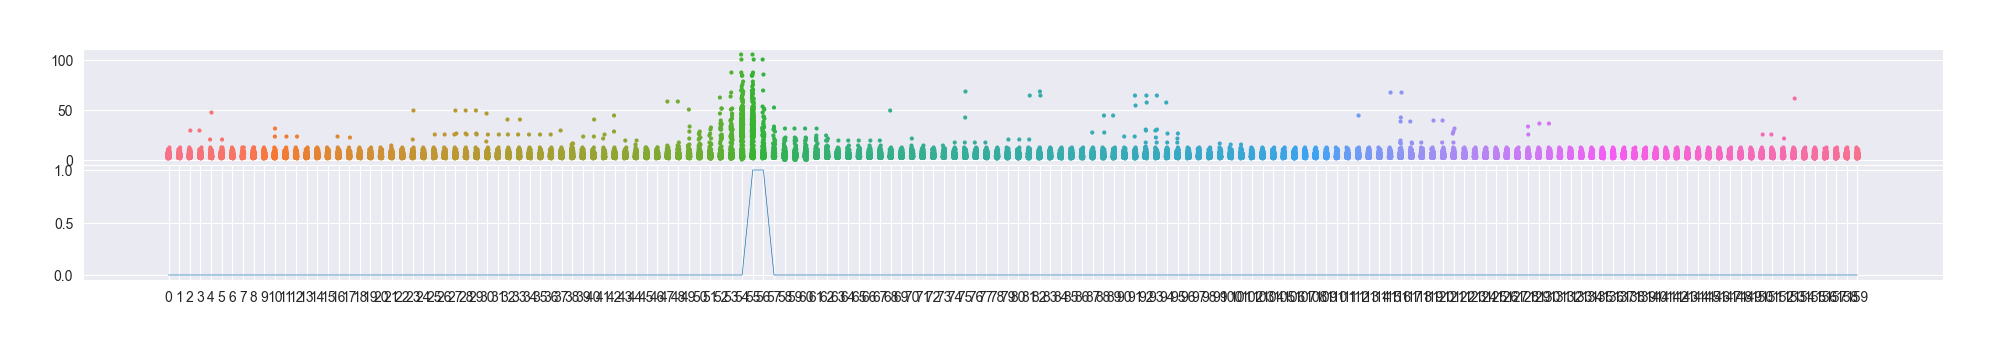

In [69]:
fig, axs = plt.subplots(2, 1, figsize=(24, 3), sharex=True)
sns.stripplot(pd.DataFrame(f),size=3, ax=axs[0])#, showfliers=False)
sns.lineplot(j.flatten())
plt.subplots_adjust(hspace=0)  # Adjust the space between the plots
plt.show()

figure saved at /Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/figure.png


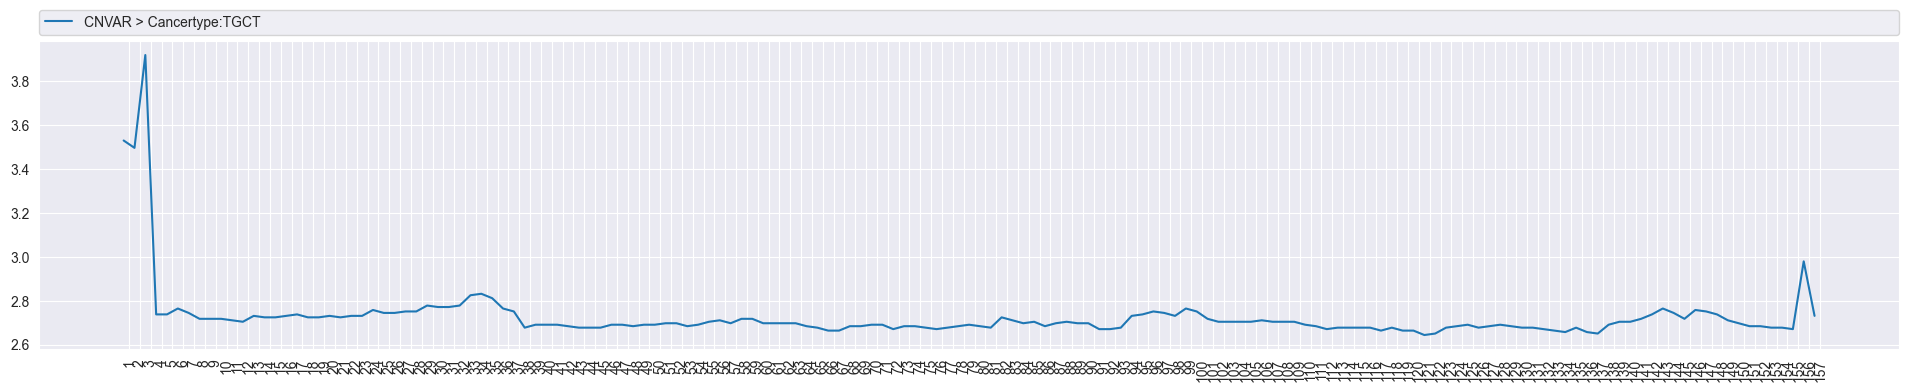

In [252]:
ca.pl.match_layers(ind.chr, ['CNVAR'], chrom='chrX', groups={'CNVAR':{'Cancertype':['TGCT']}},                   
                   save_fig=True, 
                   path='/Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 3/', 
                   normal_y=False, 
                   aggregation='mean')

In [216]:
df.sort_values('CNVAR;Cancertype:GBM')

,Unnamed: 0,CNVAR;Cancertype:GBM,CNVAR;Cancertype:OV,CNVAR;Cancertype:LUAD,CNVAR;Cancertype:LUSC,CNVAR;Cancertype:PRAD,CNVAR;Cancertype:UCEC,CNVAR;Cancertype:BLCA,CNVAR;Cancertype:ESCA,CNVAR;Cancertype:PAAD,...,CNVAR;Cancertype:HNSC,CNVAR;Cancertype:LAML,CNVAR;Cancertype:READ,CNVAR;Cancertype:LGG,CNVAR;Cancertype:DLBC,CNVAR;Cancertype:KICH,CNVAR;Cancertype:UCS,CNVAR;Cancertype:ACC,CNVAR;Cancertype:PCPG,CNVAR;Cancertype:UVM
409,COTEs;COTEs>1009_MER4D1,0.000000,1.000000,1.000000,0.329849,0.886830,1.000000,0.160354,0.708356,0.708356,...,0.997813,1.000000,1.000000,1.000000,0.400679,1.0,0.744000,1.000000,1.000000,0.214756
375,COTEs;COTEs>526_L1M3c,0.049644,1.000000,1.000000,0.083072,0.423540,0.850246,0.337902,0.114142,0.049644,...,0.227289,0.322133,0.253911,1.000000,1.000000,1.0,0.634861,0.264767,1.000000,0.317158
269,COTEs;COTEs>970_MER34,0.049644,1.000000,1.000000,0.000000,0.396146,0.768611,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.227289,1.0,0.000000,0.000000,0.049644,0.000000
432,COTEs;COTEs>574_L1MD3,0.083072,0.367189,1.000000,1.000000,1.000000,0.444022,0.925679,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.437265,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
368,COTEs;COTEs>569_L1MCb,0.083072,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.897808,1.0,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,COTEs;COTEs>1117_MER91B,1.000000,1.000000,0.305581,0.400679,0.628579,0.999915,1.000000,0.450987,0.490781,...,0.430308,0.083072,0.988104,1.000000,0.049644,1.0,0.349101,0.642774,0.317158,1.000000
158,COTEs;COTEs>980_MER41A,1.000000,1.000000,0.752525,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.523952,1.000000,1.0,1.000000,1.000000,0.948564,1.000000
156,COTEs;COTEs>604_L1MEj,1.000000,1.000000,0.382278,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
184,COTEs;COTEs>94_AluSg7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.470810,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [214]:
df = pd.read_csv(parent_dir+f'/analysis/experiment16/loss/{c}__qval_n_hit.csv', index_col=False)


['1009_MER4D1']


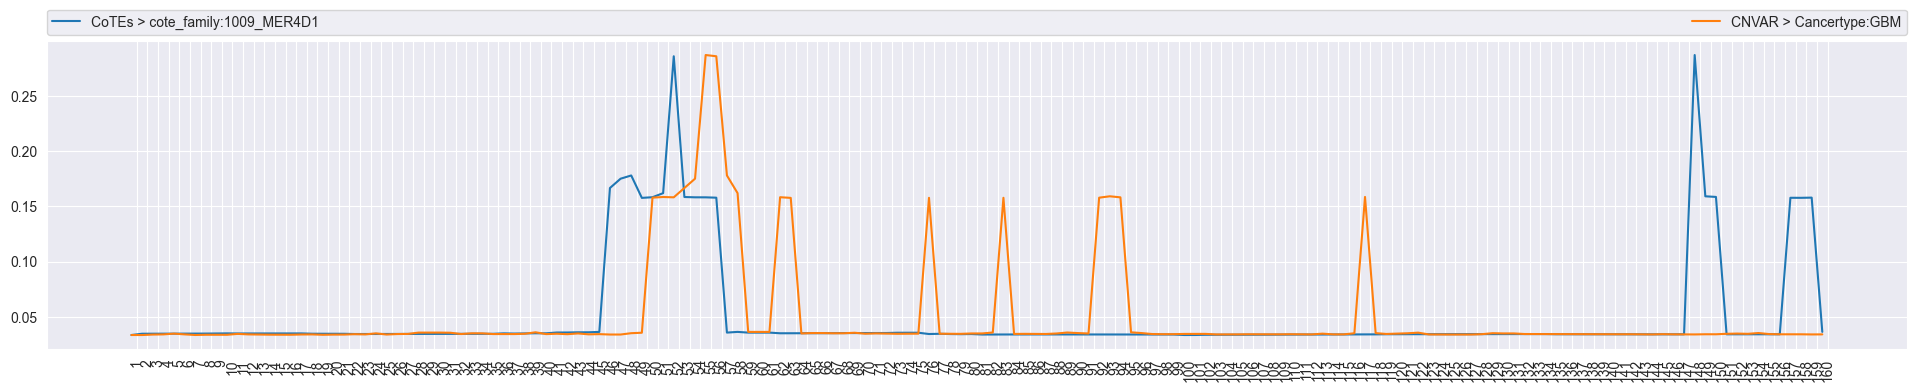

In [132]:
c = 'chr7'
ct = 'GBM'
df = pd.read_csv(parent_dir+f'/analysis/experiment16/loss/{c}__qval_n_hit.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
q_ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}')

df = pd.read_csv(parent_dir+f'/analysis/experiment16/loss/{c}__n_hits.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')
ct_df = df[[f'CNVAR;Cancertype:{ct}']].sort_values(by=f'CNVAR;Cancertype:{ct}', ascending=False)

families = [i.split('>')[-1] for i in q_ct_df.loc[q_ct_df.values<=0.031].index.values]
print(families)
ca.pl.match_layers(ind.chr, ['CoTEs', 'CNVAR'], chrom=c, groups={'CNVAR':{'Cancertype':[ct]}, 
                                                                    'CoTEs':{'cote_family':families}})